# T-DEV-810

- Jonathan Khalifa
- Valentin Noel
- Fabrice Sumsa
- Bastien Angles
- Kevan Sadeghi

# Latest Version : 83%, 3 targets (norm / vir / bact) with CLAHE


 
### Imports

In [17]:
import glob
import imutils
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import math
from tqdm.notebook import tqdm
import cv2
from sklearn.metrics import classification_report,confusion_matrix
import itertools
from livelossplot import PlotLossesKeras
import keras
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten,BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

<br/><br/><br/><br/>
### Global vars
- Common batch size values : 16 - 32 - 64 - 128
- Epochs to determine the duration of our model training
- Train size sample for the total amount of equally distributed images before data augmentation.
- Max train sample size is 2682. max val to have equally distributed image categories.
- Image size(width, height). according to this studdy https://pubs.rsna.org/doi/full/10.1148/ryai.2019190015 the optimal size is 256x256. But lacking enough calculation power, we will remain at 64x64 while still getting decent results.

In [2]:
BATCH_SIZE = 16
EPOCHS = 18
TRAIN_SAMPLE_SIZE = 4023
IMG_SIZE = 60
PATH_SAVE_MODEL = "SAVED_MODELS/T-DEV-810/training6/cp.ckpt"

PATH_VAL = "/Users/jk/Downloads/chest_Xray/val/*/*"
PATH_TRAIN_VIR = "/Users/jk/Downloads/chest_Xray/train/PNEUMONIA/*virus*.*"
PATH_TRAIN_BACT = "/Users/jk/Downloads/chest_Xray/train/PNEUMONIA/*bacteria*.*"
PATH_TRAIN_NORM = "/Users/jk/Downloads/chest_Xray/train/NORMAL/*"
PATH_TEST_NORM = "/Users/jk/Downloads/chest_Xray/test/NORMAL/*"
PATH_TEST_VIR = "/Users/jk/Downloads/chest_Xray/test/PNEUMONIA/*virus*.*"
PATH_TEST_BACT = "/Users/jk/Downloads/chest_Xray/test/PNEUMONIA/*bacteria*.*"

PATH_EXAMPLE_IMAGE1 = "/Users/jk/Downloads/chest_Xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg"
PATH_EXAMPLE_IMAGE2 = "/Users/jk/Downloads/chest_Xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg"
PATH_EXAMPLE_IMAGE3 = "/Users/jk/Downloads/chest_Xray/train/PNEUMONIA/person995_virus_1676.jpeg"

<br/><br/><br/><br/>
### Load the Dataset
- We plot the distribution of our image's labels to see the disparities.
- The plot reveals that we will need to redistribute the datasets for better training.

We have  1345  viral pneumonia train files
We have  1341  normal train files
We have  2530  bacterial pneumonia train files
We have  148  viral pneumonia test files
We have  234  normal test files
We have  242  bacterial pneumonia test files
We have  16  total validation files


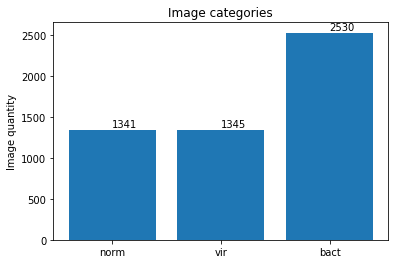

In [3]:
# Load the training files
files_train_vir = glob.glob(PATH_TRAIN_VIR)
files_train_bact = glob.glob(PATH_TRAIN_BACT)
files_train_norm = glob.glob(PATH_TRAIN_NORM)
files_test_norm = glob.glob(PATH_TEST_NORM)
files_test_vir = glob.glob(PATH_TEST_VIR)
files_test_bact = glob.glob(PATH_TEST_BACT)
files_validate = glob.glob(PATH_VAL)

# shuffle
random.shuffle(files_train_vir)
random.shuffle(files_train_bact)
random.shuffle(files_train_norm)
random.shuffle(files_test_vir)
random.shuffle(files_test_bact)
random.shuffle(files_test_norm)


print('We have ', len(files_train_vir) ,' viral pneumonia train files')
print('We have ', len(files_train_norm) ,' normal train files')
print('We have ', len(files_train_bact) ,' bacterial pneumonia train files')
print('We have ', len(files_test_vir) ,' viral pneumonia test files')
print('We have ', len(files_test_norm) ,' normal test files')
print('We have ', len(files_test_bact) ,' bacterial pneumonia test files')
print('We have ', len(files_validate) ,' total validation files')

        
# distrib plot 
x = ('norm', 'vir', 'bact')
y = [len(files_train_norm),len(files_train_vir),len(files_train_bact)]
plt.bar(x, height= y)
plt.ylabel('Image quantity')
plt.title('Image categories')
for i, v in enumerate(y):
    plt.text(x[i] , v+30, str(v))
plt.show()

<br/><br/><br/><br/>
### We make a new training batch with equaly distributed image categories. 
- Similar quantities of each category will make better training.
- TRAIN_SAMPLE_SIZE can at most be twice the val of the cat with the less images : min([len(files_train_sick),len(files_train_norm)])



444


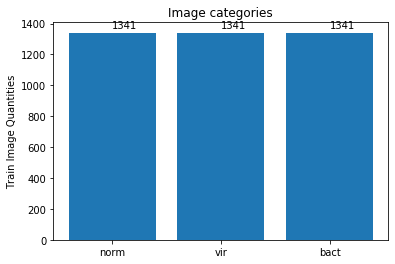

Total images in sample equally distributed dataset :  4023


In [4]:
# We will also make a smaller equally distributed dataset for testing purposes
train_subsample_size = int(TRAIN_SAMPLE_SIZE/3)
files_train_sample = files_train_norm[:train_subsample_size] + files_train_vir[:train_subsample_size] + files_train_bact[:train_subsample_size]
random.shuffle(files_train_sample)


t = min([len(files_test_bact),len(files_test_norm),len(files_test_vir)])
files_test_final = files_test_norm[:t] + files_test_vir[:t] + files_test_bact[:t]
random.shuffle(files_test_final)
print(len(files_test_final))

# distrib plot 
x = ('norm', 'vir', 'bact')
y = [len(files_train_norm[:train_subsample_size]),len(files_train_vir[:train_subsample_size]),len(files_train_bact[:train_subsample_size])]
plt.bar(x, height= y)
plt.ylabel('Train Image Quantities')
plt.title('Image categories')
for i, v in enumerate(y):
    plt.text(x[i] , v+30, str(v))
plt.show()

print('Total images in sample equally distributed dataset : ', len(files_train_sample))

<br/><br/><br/><br/>
### Scatter plot for image dimensions distribution will help us see if we need to reshape our images or not.
- notice that nearly all of our images have different sizes. We will need to resize them all. 

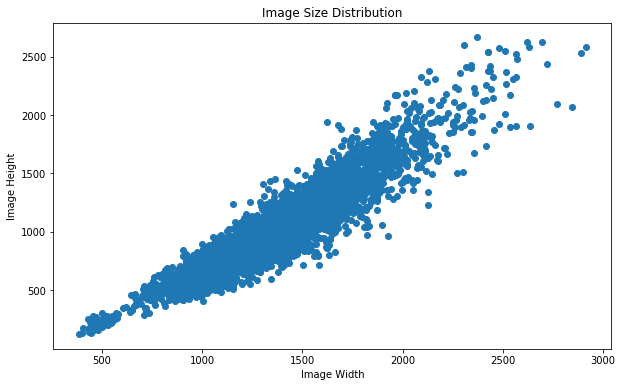

In [5]:
xscatter = []
yscatter = []
for a in files_train_sample:
    img = cv2.imread(a)
    height, width, channels = img.shape
    xscatter.append(height)
    yscatter.append(width)
    

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x = yscatter, y = xscatter)

plt.xlabel("Image Width")
plt.ylabel("Image Height")
plt.title("Image Size Distribution")
plt.show()

<br/><br/><br/><br/>
### A bit of research before preparing our data
#### We have tested two options as for image pimping. examples below :
- We either apply CLAHE algorithm on our images in order to enhance contrasts on our images
- Or we apply segmentation to our images in order to enhance contrasts on our image's lungs
#### In the end we will use CLAHE for better results, but both examples of image preprocessing remains below

 Example of image enhancement with Segmentation 


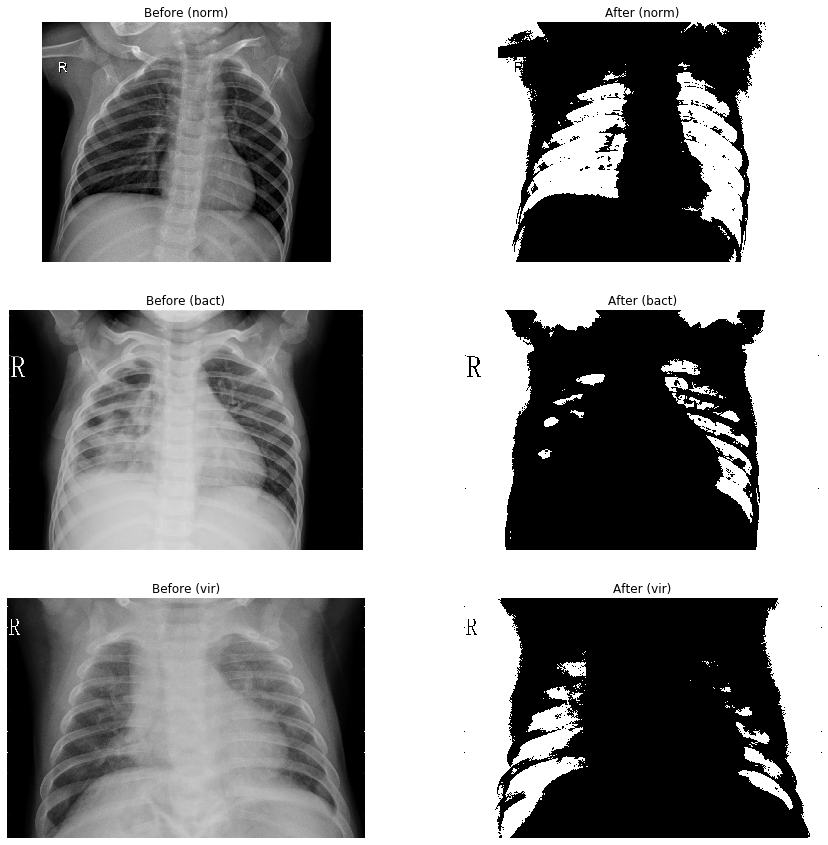

 Example of image enhancement with CLAHE 


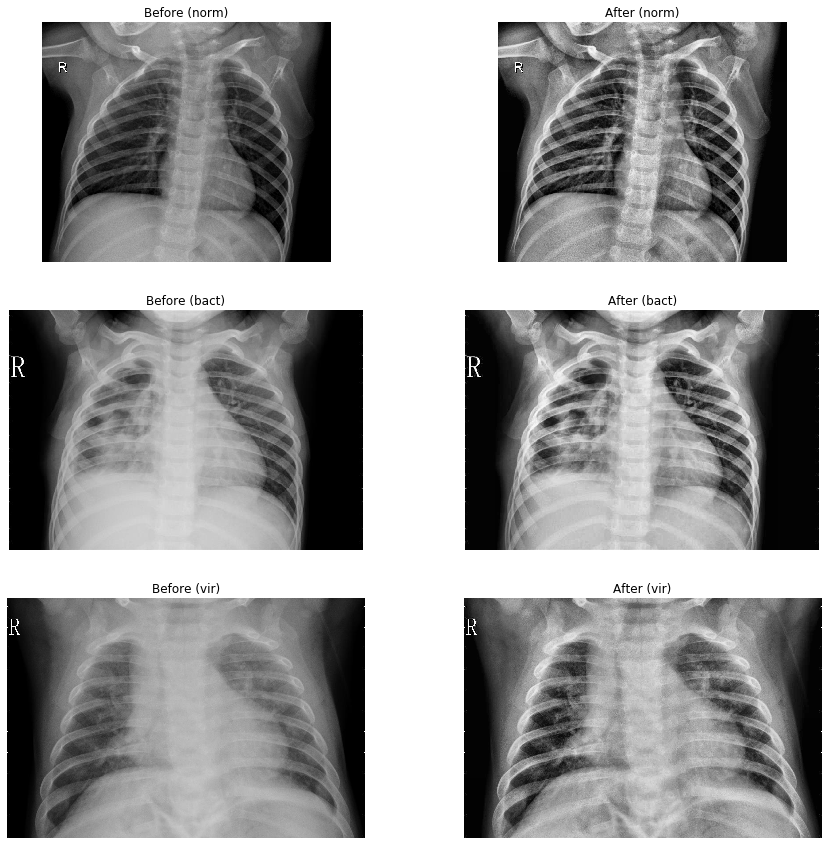

In [5]:
#random image as for example
bgr = cv2.imread(PATH_EXAMPLE_IMAGE2,0)
bgr2 = cv2.imread(PATH_EXAMPLE_IMAGE1,0)
bgr3 = cv2.imread(PATH_EXAMPLE_IMAGE3,0)
bgr4 = cv2.imread(PATH_EXAMPLE_IMAGE2,0)
bgr5 = cv2.imread(PATH_EXAMPLE_IMAGE1,0)
bgr6 = cv2.imread(PATH_EXAMPLE_IMAGE3,0)



# SEMGENTATION
ret, cl = cv2.threshold(bgr,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
ret, cl2 = cv2.threshold(bgr2,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
ret, cl3 = cv2.threshold(bgr3,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
cl = cv2.cvtColor(cl,cv2.COLOR_GRAY2BGR)
cl2 = cv2.cvtColor(cl2,cv2.COLOR_GRAY2BGR)
cl3 = cv2.cvtColor(cl3,cv2.COLOR_GRAY2BGR)
bgr3 = cv2.cvtColor(bgr3, cv2.COLOR_BGR2RGB)
bgr2 = cv2.cvtColor(bgr2, cv2.COLOR_BGR2RGB)
bgr = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)


print(" Example of image enhancement with Segmentation ")


# plotting the results
plt.figure(figsize=(15,15))
plt.subplot(321)
plt.axis('off')
plt.imshow(bgr)
plt.title("Before (norm)")
plt.subplot(322)
plt.axis('off')
plt.imshow(cl)
plt.title("After (norm)")
plt.subplot(323)
plt.axis('off')
plt.imshow(bgr2)
plt.title("Before (bact)")
plt.subplot(324)
plt.axis('off')
plt.imshow(cl2)
plt.title("After (bact)")
plt.subplot(325)
plt.axis('off')
plt.imshow(bgr3)
plt.title("Before (vir)")
plt.subplot(326)
plt.axis('off')
plt.imshow(cl3)
plt.title("After (vir)")
plt.show()





#CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl4 = clahe.apply(bgr4)
cl5 = clahe.apply(bgr5)
cl6 = clahe.apply(bgr6)
cl6 = cv2.cvtColor(cl6, cv2.COLOR_BGR2RGB)
cl5 = cv2.cvtColor(cl5, cv2.COLOR_BGR2RGB)
cl4 = cv2.cvtColor(cl4, cv2.COLOR_BGR2RGB)
bgr6 = cv2.cvtColor(bgr6, cv2.COLOR_BGR2RGB)
bgr5 = cv2.cvtColor(bgr5, cv2.COLOR_BGR2RGB)
bgr4 = cv2.cvtColor(bgr4, cv2.COLOR_BGR2RGB)


print(" Example of image enhancement with CLAHE ")


# plotting the results
plt.figure(figsize=(15,15))
plt.subplot(321)
plt.axis('off')
plt.imshow(bgr4)
plt.title("Before (norm)")
plt.subplot(322)
plt.axis('off')
plt.imshow(cl4)
plt.title("After (norm)")
plt.subplot(323)
plt.axis('off')
plt.imshow(bgr5)
plt.title("Before (bact)")
plt.subplot(324)
plt.axis('off')
plt.imshow(cl5)
plt.title("After (bact)")
plt.subplot(325)
plt.axis('off')
plt.imshow(bgr6)
plt.title("Before (vir)")
plt.subplot(326)
plt.axis('off')
plt.imshow(cl6)
plt.title("After (vir)")
plt.show()





<br/><br/><br/><br/>
### Time to fix our datasets
#### For this data to be usefull, we will have to do the following :
- create the labels 
- put all the images to the same size
- put all the images to RGB (3 channels)
- enhance our contrasts with CLAHE (Contrast-Limited Adaptive Histogram Equalization)

In [6]:
# label , resize and RGB
def fixData(dataset):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)) 
    y_data = []
    x_data = []
    for file in dataset:
        image = cv2.imread(file)
        image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY) ### CLAHE
        image = clahe.apply(image) ### CLAHE
        image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))

        data = np.array(image)
        x_data.append(data)
        
        # LABELS
        if("virus" in file):
            target = 1
        elif("bacteria" in file):
            target = 2
        else:
            target = 0

        y_data.append(target)    
    x_data = np.asarray(x_data)    
    y_data = np.asarray(y_data)
    y_data = to_categorical(y_data,3)
    return (x_data,y_data)


# Training images
(x_train_sample, y_train_sample) = fixData(files_train_sample)

# Testing images
(x_test, y_test) = fixData(files_test_final)

# Validation images
(x_val, y_val) = fixData(files_validate)


# stats to be printed
print("Features train sample shape : ", x_train_sample.shape)
print("Targets train sample shape  : ", y_train_sample.shape)
print("Features test shape         : ", x_test.shape)
print("Targets test shape          : ", y_test.shape)
print("Features val shape          : ", x_val.shape)
print("Targets val shape           : ", y_val.shape)


# Normalize data
def normData(data):
    xmax = data.max()
    data = data / xmax
    return data


print('Before normalization        : min={}, max={}'.format(x_train_sample.min(), x_train_sample.max()))
x_train_sample = normData(x_train_sample)
x_test = normData(x_test)
print('After normalisation         : min={}, max={}'.format(x_train_sample.min(), x_train_sample.max()))

Features train sample shape :  (4023, 60, 60, 3)
Targets train sample shape  :  (4023, 3)
Features test shape         :  (444, 60, 60, 3)
Targets test shape          :  (444, 3)
Features val shape          :  (16, 60, 60, 3)
Targets val shape           :  (16, 3)
Before normalization        : min=0, max=255
After normalisation         : min=0.0, max=1.0


### Preparing the different data blocs for k-fold cross validation

In [7]:

merge_x_train_test = (x_train_sample, x_test)
merge_x_train_test = np.vstack(merge_x_train_test)
print("merge_x_train_test shape           : ", merge_x_train_test.shape)


merge_y_train_test = (y_train_sample, y_test)
merge_y_train_test = np.vstack(merge_y_train_test)
print("merge_y_train_test shape           : ", merge_y_train_test.shape)



# devide in 3 blocs for k fond cross validation
x_bloc1, x_bloc2, x_bloc3 = np.array_split(merge_x_train_test,3);
y_bloc1, y_bloc2, y_bloc3 = np.array_split(merge_y_train_test,3);

print("X bloc1 shape : ",x_bloc1.shape)
print("Y bloc1 shape : ",y_bloc1.shape)
print("X bloc2 shape : ",x_bloc2.shape)
print("Y bloc2 shape : ",y_bloc2.shape)
print("X bloc3 shape : ",x_bloc3.shape)
print("Y bloc3 shape : ",y_bloc3.shape)


merge_x_train_test shape           :  (4467, 60, 60, 3)
merge_y_train_test shape           :  (4467, 3)
X bloc1 shape :  (1489, 60, 60, 3)
Y bloc1 shape :  (1489, 3)
X bloc2 shape :  (1489, 60, 60, 3)
Y bloc2 shape :  (1489, 3)
X bloc3 shape :  (1489, 60, 60, 3)
Y bloc3 shape :  (1489, 3)


<br/><br/><br/><br/>
### Check the Data
-Here we will display a small sample of our clean dataset allong with it's labels

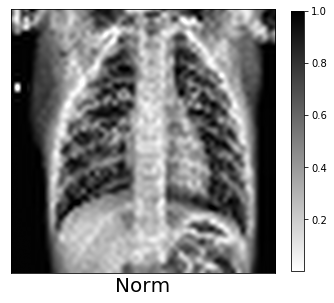

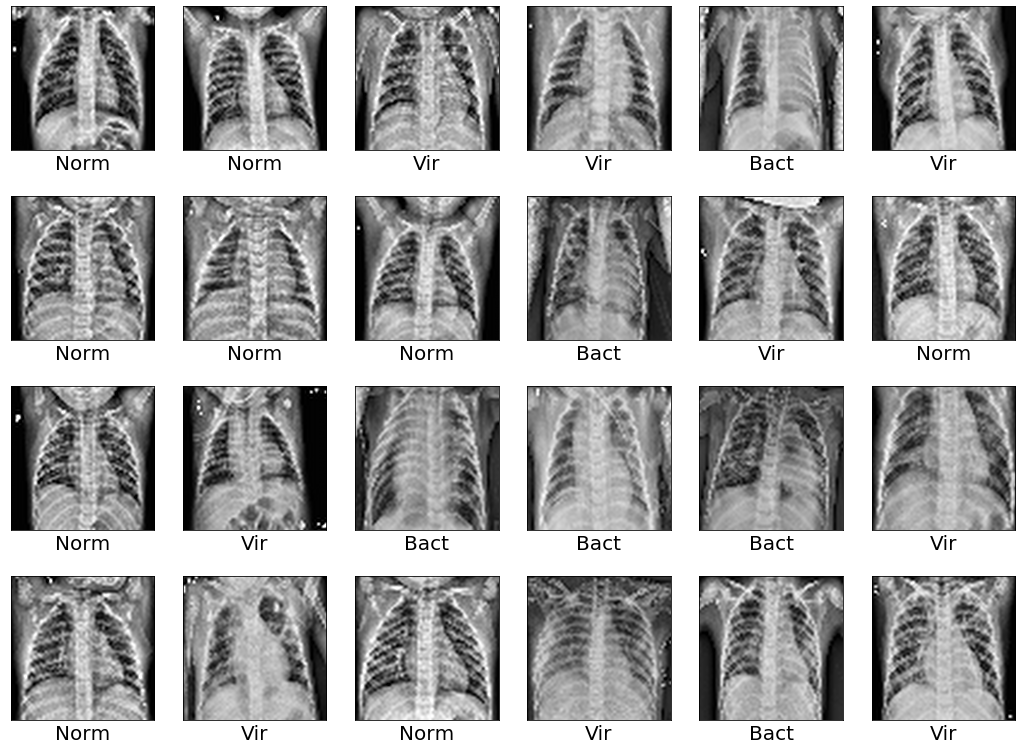

In [8]:


# Targets names for plotting
def targetNames(targets):
    target_names = []
    for target in targets:
        if(target[0] > 0):
            target_names.append("Norm")
        elif(target[1] > 0):
            target_names.append("Vir")
        elif(target[2] > 0):
            target_names.append("Bact")
    return target_names



# Show some images in a grid, with legends 
def plot_images(x,y=None, indices='all', columns=12, x_size=1, y_size=1,
                colorbar=False, y_pred=None, cm='binary', norm=None, y_padding=0.35, spines_alpha=1,
                fontsize=20, interpolation='lanczos', save_as='auto'):
    """
    args:
        x             : images - Shapes must be (-1,lx,ly) (-1,lx,ly,1) or (-1,lx,ly,3)
        y             : real classes or labels or None (None)
        indices       : indices of images to show or 'all' for all ('all')
        columns       : number of columns (12)
        x_size,y_size : figure size (1), (1)
        colorbar      : show colorbar (False)
        y_pred        : predicted classes (None)
        cm            : Matplotlib color map (binary)
        norm          : Matplotlib imshow normalization (None)
        y_padding     : Padding / rows (0.35)
        spines_alpha  : Spines alpha (1.)
        font_size     : Font size in px (20)
        save_as       : Filename to use if save figs is enable ('auto')
    """
    if indices=='all': indices=range(len(x))
    if norm and len(norm) == 2: norm = matplotlib.colors.Normalize(vmin=norm[0], vmax=norm[1])
    draw_labels = (y is not None)
    draw_pred   = (y_pred is not None)
    rows        = math.ceil(len(indices)/columns)
    fig=plt.figure(figsize=(columns*x_size, rows*(y_size+y_padding)))
    n=1
    for i in indices:
        axs=fig.add_subplot(rows, columns, n)
        n+=1
        # ---- Shape is (lx,ly)
        if len(x[i].shape)==2:
            xx=x[i]
        # ---- Shape is (lx,ly,n)
        if len(x[i].shape)==3:
            (lx,ly,lz)=x[i].shape
            if lz==1: 
                xx=x[i].reshape(lx,ly)
            else:
                xx=x[i]
        img=axs.imshow(xx,   cmap = cm, norm=norm, interpolation=interpolation)
        axs.spines['right'].set_visible(True)
        axs.spines['left'].set_visible(True)
        axs.spines['top'].set_visible(True)
        axs.spines['bottom'].set_visible(True)
        axs.spines['right'].set_alpha(spines_alpha)
        axs.spines['left'].set_alpha(spines_alpha)
        axs.spines['top'].set_alpha(spines_alpha)
        axs.spines['bottom'].set_alpha(spines_alpha)
        axs.set_yticks([])
        axs.set_xticks([])
        if draw_labels and not draw_pred:
            axs.set_xlabel(y[i],fontsize=fontsize)
        if draw_labels and draw_pred:
            if y[i]!=y_pred[i]:
                axs.set_xlabel(f'{y_pred[i]} ({y[i]})',fontsize=fontsize)
                axs.xaxis.label.set_color('red')
            else:
                axs.set_xlabel(y[i],fontsize=fontsize)
        if colorbar:
            fig.colorbar(img,orientation="vertical", shrink=0.65)
    plt.show()


y_names = targetNames(merge_y_train_test)
plot_images(merge_x_train_test, y_names, [0], x_size=7, y_size=7, colorbar=True)
plot_images(merge_x_train_test, y_names, range(0,24),x_size=3, y_size=3, columns=6)

<br/><br/><br/><br/>
### Data Augmentation

#### In order to avoid overfitting problem, we need to expand artificially our dataset. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same.
- Randomly rotate some training images by 30 degrees
- Randomly Zoom by 20% some training images
- Randomly shift images horizontally by 10% of the width
- Randomly shift images vertically by 10% of the height
- Randomly flip images horizontally. Once our model is ready, we fit the training dataset.

In [8]:
datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,                  # apply ZCA whitening
        rotation_range = 30,                  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2,                     # Randomly zoom image 
        width_shift_range=0.1,                # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,               # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,               # randomly flip images
        vertical_flip=False)                  # randomly flip images


<br/><br/><br/><br/>
### The Model
#### We will use a convolutional neural network in order to classify our images
#### Specs : 
- 3 convo layers with increasing amount of filters.
- large initial kernell size for catching larger details, then smaller kernells for catching small details
- activation function remains RELU accross the board exept for a final softmax in order to deal with our target probabilities.
- 3 max pooling layers with a grid size of 2x2
- 2 dropouts that will disactivate respectivly 20% and 30% of the neurons
- ~We will use Nadam optimizer in order to benefit of momentum.~
- We will use Adam as optimizer

In [23]:
# 60x60 images
# batch 8
# lr 0.0002
# perf [0.5087339878082275, 0.8333333134651184] WITHOUT crossval
"""
def create_model():
    model = keras.models.Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(4,4), input_shape=(IMG_SIZE,IMG_SIZE,3), activation='relu',))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(2,2), activation='relu',))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(2,2), activation='relu',))
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Dropout(0.2))
    model.add(Flatten())

    model.add(Dense(16, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(64, activation='relu'))
    
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))


    #optimizers
    opt = keras.optimizers.Adam(learning_rate=0.0002) 
    
    
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model
    

# Create a basic model instance
model = create_model()

model.summary()



"""





# 77% with cross val
def create_model():
    model = keras.models.Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(4,4),strides=1, input_shape=(IMG_SIZE,IMG_SIZE,3), activation='relu',))
    model.add(Conv2D(filters=32, kernel_size=(4,4),strides=1, activation='relu',))
    model.add(MaxPool2D(pool_size=(2,2), strides = 2))
    
    model.add(Conv2D(filters=64, kernel_size=(2,2),strides=1, activation='relu',))
    model.add(Conv2D(filters=64, kernel_size=(2,2),strides=1, activation='relu',))
    model.add(MaxPool2D(pool_size=(2,2), strides = 2))
    
    model.add(Conv2D(filters=128, kernel_size=(2,2),strides=1, activation='relu',))
    model.add(Conv2D(filters=128,name='lastConv', kernel_size=(2,2),strides=1, activation='relu',))
    model.add(MaxPool2D(pool_size=(2,2),name='1', strides = 2))
    
    model.add(Dropout(0.2,name='2'))
    
    model.add(Flatten(name='3'))

    

    

    model.add(Dense(512,name='4', activation='relu'))
    
    model.add(Dropout(0.2,name='5'))
    model.add(Dense(3,name='6', activation='softmax'))


    #optimizers
    opt = keras.optimizers.Adam(learning_rate=0.0002) 
    
    
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model
    

# Create a basic model instance
model = create_model()

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 57, 57, 32)        1568      
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 54, 54, 32)        16416     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 27, 27, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 26, 26, 64)        8256      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 25, 25, 64)        16448     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 11, 11, 128)      

<br/><br/><br/><br/>
## Train the model

- learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated
- Best learning rate for Adam opti : 3e-4 according to google but for our model it differs a bit.
- We will dynamically plot each epoch as the model trains.
- The model will stop training if 3 consecutive epochs overfit.
- We save the model's weights for later re-use.
- We have a ladder learning rate decay that triggers whenever we have 2 consecutive epochs that overfit.
### Callbacks

In [10]:
# directory to save model's weights
checkpoint_dir = os.path.dirname(PATH_SAVE_MODEL)

# Create a callback that saves the model's weights
cp_callback = keras.callbacks.ModelCheckpoint(filepath=PATH_SAVE_MODEL,
                                              save_weights_only=True,
                                              verbose=1)

# Create a callback to stop the model if overfits
early_stop = EarlyStopping(monitor='val_loss',patience=3)
lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.35,
                              patience=2,
                              verbose=2,
                              mode='auto')



"""
# FOR TESTING HYPERPARAMS AND FINE TUNING THE MODEL

x_train = (x_bloc1, x_bloc2)
x_train = np.vstack(x_train)
y_train = (y_bloc1, y_bloc2)
y_train = np.vstack(y_train)
x_test = x_bloc3
y_test = y_bloc3
        
history = model.fit(datagen.flow(x_train,y_train,batch_size = 8),
                    epochs = 12, 
                    validation_data = datagen.flow(x_test, y_test),
                    callbacks = [early_stop,
                                 lr_reduce,
                                 #cp_callback,
                                 PlotLossesKeras()])
"""

'\n# FOR TESTING HYPERPARAMS AND FINE TUNING THE MODEL\n\nx_train = (x_bloc1, x_bloc2)\nx_train = np.vstack(x_train)\ny_train = (y_bloc1, y_bloc2)\ny_train = np.vstack(y_train)\nx_test = x_bloc3\ny_test = y_bloc3\n        \nhistory = model.fit(datagen.flow(x_train,y_train,batch_size = 8),\n                    epochs = 12, \n                    validation_data = datagen.flow(x_test, y_test),\n                    callbacks = [early_stop,\n                                 lr_reduce,\n                                 #cp_callback,\n                                 PlotLossesKeras()])\n'

In [11]:
#print("metrics: ", model.evaluate(x_test,y_test,verbose=1))



### Training
#### training will be done in 3 steps for cross validation :
- step 1 : train = bloc1 + bloc2 , test = bloc 3
- step 2 : train = bloc2 + bloc3 , test = bloc 1
- step 3 : train = bloc1 + bloc3 , test = bloc 2


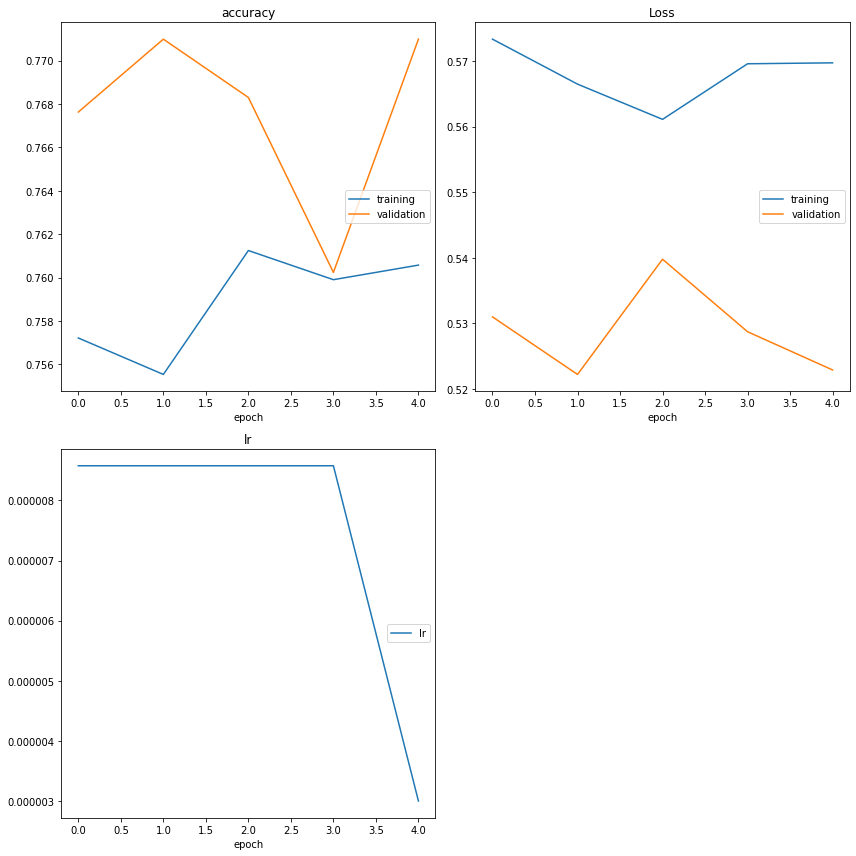

accuracy
	training         	 (min:    0.756, max:    0.761, cur:    0.761)
	validation       	 (min:    0.760, max:    0.771, cur:    0.771)
Loss
	training         	 (min:    0.561, max:    0.573, cur:    0.570)
	validation       	 (min:    0.522, max:    0.540, cur:    0.523)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
['loss', 'accuracy']
[(0.5290514230728149, 0.7743452191352844), (0.547651469707489, 0.7555406093597412), (0.5143612027168274, 0.7736735939979553)]


In [13]:


scores = []
index = [0,1,2]
for i in index:
    if i == 0:
        x_train = (x_bloc1, x_bloc2)
        x_train = np.vstack(x_train)
        y_train = (y_bloc1, y_bloc2)
        y_train = np.vstack(y_train)
        x_test = x_bloc3
        y_test = y_bloc3
    if i == 1:
        x_train = (x_bloc2, x_bloc3)
        x_train = np.vstack(x_train)
        y_train = (y_bloc2, y_bloc3)
        y_train = np.vstack(y_train)
        x_test = x_bloc1
        y_test = y_bloc1
    if i == 2:
        x_train = (x_bloc1, x_bloc3)
        x_train = np.vstack(x_train)
        y_train = (y_bloc1, y_bloc3)
        y_train = np.vstack(y_train)
        x_test = x_bloc2
        y_test = y_bloc2
    
    # aug data
    datagen.fit(x_train)

    
    

    PATH_SAVE_MODEL = "SAVED_MODELS/T-DEV-810/trainingSplit"+str(index)+"/cp.ckpt"

    # directory to save model's weights
    checkpoint_dir = os.path.dirname(PATH_SAVE_MODEL)

    # Create a callback that saves the model's weights
    cp_callback = keras.callbacks.ModelCheckpoint(filepath=PATH_SAVE_MODEL,
                                                  save_weights_only=True,
                                                  verbose=1)

    # Create a callback to stop the model if overfits
    early_stop = EarlyStopping(monitor='val_loss',patience=3)
    lr_reduce = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.35,
                                  patience=2,
                                  verbose=2,
                                  mode='auto')


    # launch training
    history_split1 = model.fit(datagen.flow(x_train,y_train,batch_size = 8),
                        epochs = 10, 
                        validation_data = datagen.flow(x_test, y_test),
                        callbacks = [early_stop,
                                     lr_reduce,
                                     cp_callback,
                                     PlotLossesKeras()])
    
    
    b = model.evaluate(x_test,y_test,verbose=0)
    #np.vstack((scores, b))
    scores.append(tuple(b))

    
# EVAL  
model.metrics_names
print(model.metrics_names)
print(scores)

<br/><br/><br/><br/>


### Performance interpretation
- In order to have a better visual representation of our models performances, we'll print a classification report
- Then we'll see how our errors are distributed on a confusion matrix
#### metrics :
- Accuracy : % d’exactitude de prediction. Good metric if equal distributed targets
- Recall : good for not equally distributed targets ( nbr of true positives / (nbr true pos + nbr false negs)
- Precision : good for not equally distributed targets (nbr of true positives / (nbr true pos + nbr false pos)
- F1 score : 2*( (precision * recall)/(precision + recall)) bon compromis entre precision et recall


              precision    recall  f1-score   support

        Bact       0.70      0.80      0.74       478
        Norm       0.84      0.97      0.90       513
         Vir       0.78      0.55      0.64       498

    accuracy                           0.77      1489
   macro avg       0.77      0.77      0.76      1489
weighted avg       0.77      0.77      0.76      1489



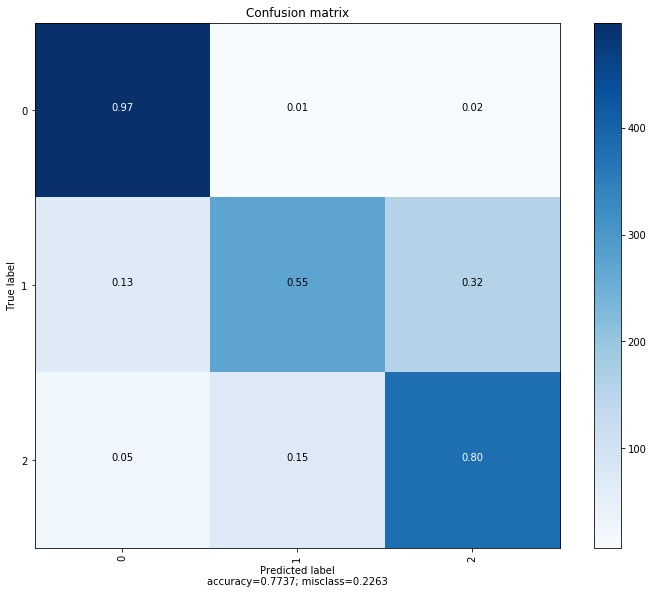

In [16]:
##################
##################
# adapt the following cells code to cross fold validation results
# add Gradient-weighted Class Activation Mapping / Grad-CAM
##################
##################

# To plot the confusions matrix
def plot_confusion_matrix(y_true,y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize=(10, 8),
                          digit_format='{:0.2f}',
                          save_as='auto'):
    """
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions
    """
    cm = confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

    
# single axis Targets names for plotting
def tgtNames(targets):
    target_names = []
    for target in targets:
        if(target == 0):
            target_names.append("Norm")
        elif(target == 1):
            target_names.append("Vir")
        elif(target == 2):
            target_names.append("Bact")
    return target_names


# put predictions and labels as single digit
predictions = np.argmax(model.predict(x_test), axis=1)
y_test_singleDigit = np.argmax(y_test, axis=1)
y_val_singleDigit = np.argmax(y_val, axis=1)
 
y_test_names = tgtNames(y_test_singleDigit)
y_pred_names = tgtNames(predictions)   
    
print(classification_report(y_test_names,y_pred_names))
plot_confusion_matrix(y_test_singleDigit,predictions, range(3), normalize=True)

In [ ]:
##### GRADCAM
###### which produces a heatmap of which regions of an image contributed strongly towards the final prediction

######### The Grad-CAM output is an activation map which localises the detected objected to a region in the image


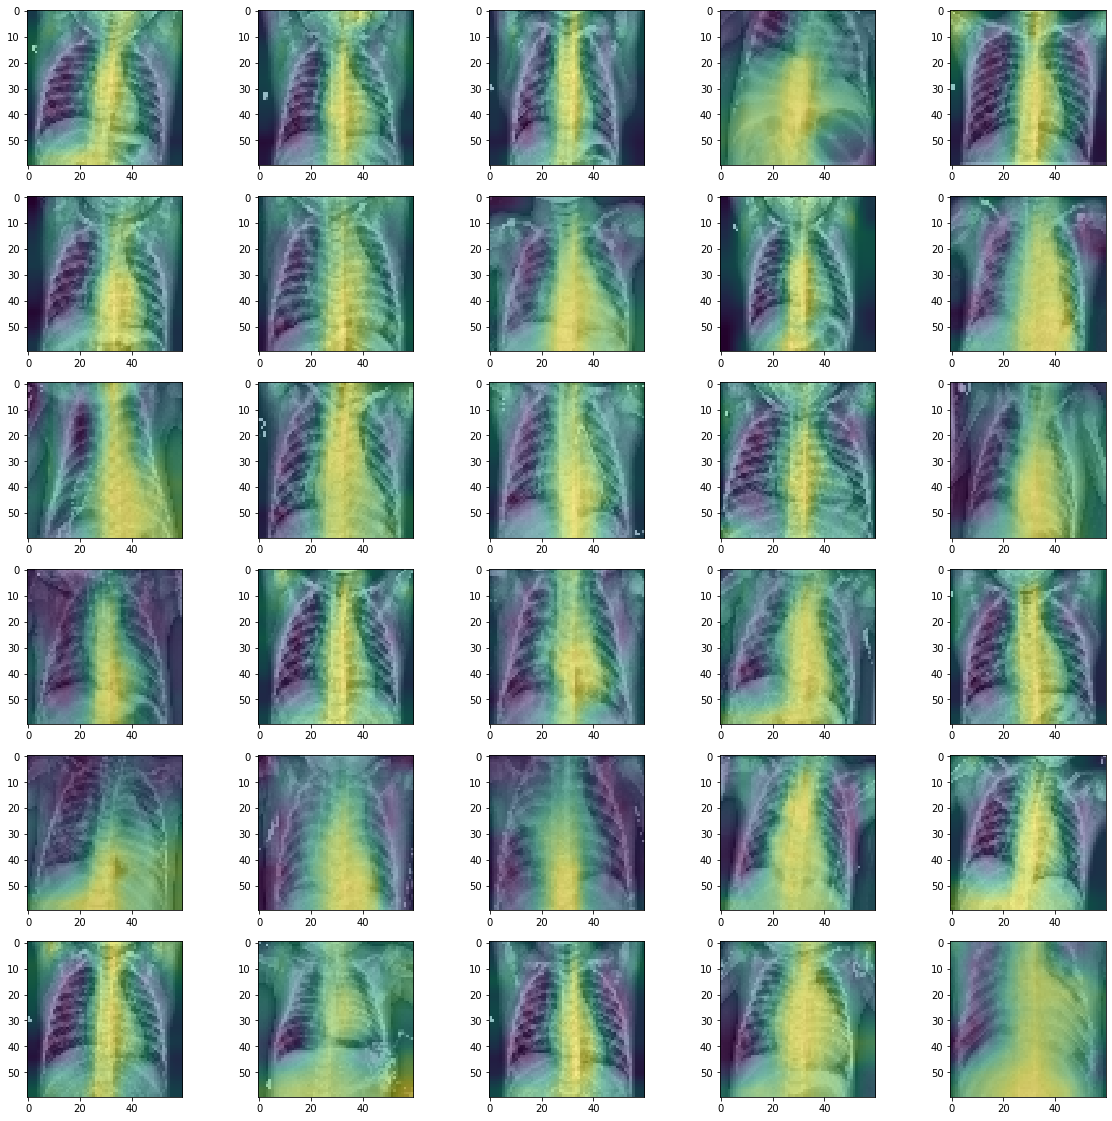

In [67]:
nbRandImages = 30
imagesSample = random.sample(list(x_train), nbRandImages)
def gradCamSample(imagesSample):
    #We get the output of the last convolution layer. We then create a model that goes up to only that layer.
    last_conv_layer = model.get_layer("lastConv")
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    # We create a model which then takes the output of the model above, and uses the remaining layers to get the final predictions.
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in ["1","2","3","4","5","6"]:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    fig = plt.figure(figsize=(20,20))
    count = 1
    for image in imagesSample :
        with tf.GradientTape() as tape:
            inputs = image[np.newaxis, ...]
            last_conv_layer_output = last_conv_layer_model(inputs)
            tape.watch(last_conv_layer_output)
            preds = classifier_model(last_conv_layer_output)
            top_pred_index = tf.argmax(preds[0])
            top_class_channel = preds[:, top_pred_index]


        grads = tape.gradient(top_class_channel, last_conv_layer_output)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        last_conv_layer_output = last_conv_layer_output.numpy()[0]
        pooled_grads = pooled_grads.numpy()
        for i in range(pooled_grads.shape[-1]):
            last_conv_layer_output[:, :, i] *= pooled_grads[i]


        # Average over all the filters to get a single 2D array
        gradcam = np.mean(last_conv_layer_output, axis=-1)
        # Clip the values (equivalent to applying ReLU)
        # and then normalise the values
        gradcam = np.clip(gradcam, 0, np.max(gradcam)) / np.max(gradcam)
        gradcam = cv2.resize(gradcam, (IMG_SIZE, IMG_SIZE))

        
        
#The Grad-CAM output can be improved further by combining with guided backpropagation, which zeroes elements in the gradients which act negatively towards the decision.
        with tf.GradientTape() as tape:
            last_conv_layer_output = last_conv_layer_model(image[np.newaxis, ...])
            tape.watch(last_conv_layer_output)
            preds = classifier_model(last_conv_layer_output)
            top_pred_index = tf.argmax(preds[0])
            top_class_channel = preds[:, top_pred_index]

        grads = tape.gradient(top_class_channel, last_conv_layer_output)[0]
        last_conv_layer_output = last_conv_layer_output[0]

        guided_grads = (
            tf.cast(last_conv_layer_output > 0, "float32")
            * tf.cast(grads > 0, "float32")
            * grads
        )

        pooled_guided_grads = tf.reduce_mean(guided_grads, axis=(0, 1))
        guided_gradcam = np.ones(last_conv_layer_output.shape[:2], dtype=np.float32)

        for i, w in enumerate(pooled_guided_grads):
            guided_gradcam += w * last_conv_layer_output[:, :, i]

        guided_gradcam = cv2.resize(guided_gradcam.numpy(), (IMG_SIZE, IMG_SIZE))
        guided_gradcam = np.clip(guided_gradcam, 0, np.max(guided_gradcam))
        guided_gradcam = (guided_gradcam - guided_gradcam.min()) / (
            guided_gradcam.max() - guided_gradcam.min()
        )

        axs=fig.add_subplot(6, 5, count)
        axs.imshow(image)
        axs.imshow(guided_gradcam, alpha=0.5)
        count = count + 1
    count = 1
        
    




gradCamSample(imagesSample)




<br/><br/><br/><br/>

### Now let's see how our model predicts on a sample of images
- notice the erroneous predictions are labeled in red

image single digit label :  0
single digit label predicted by model :  [0]


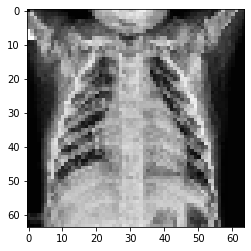

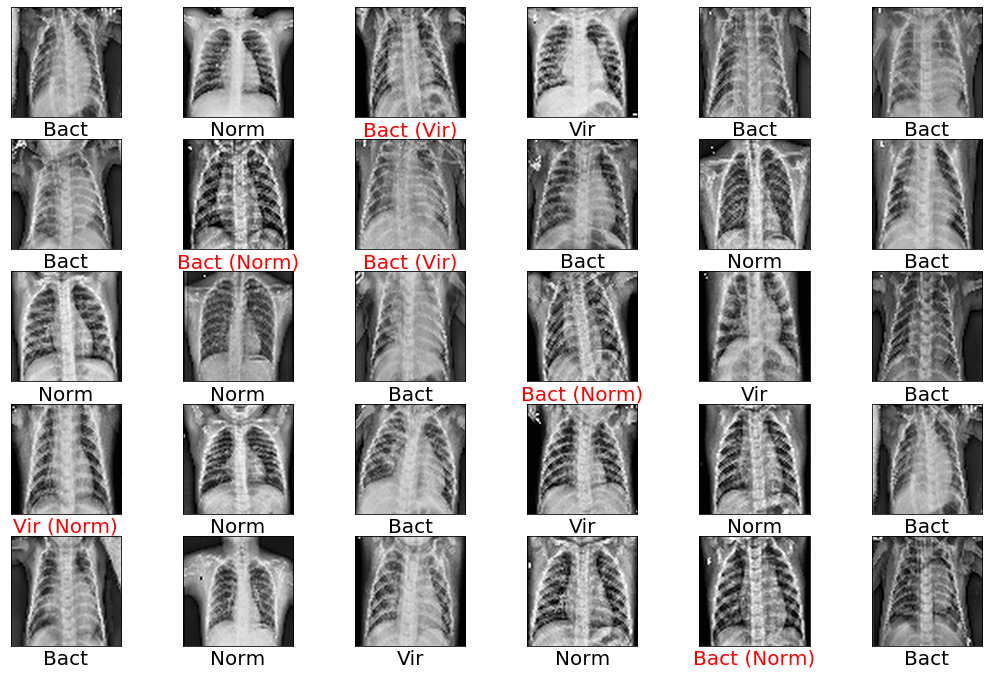

In [52]:
my_image = x_val[11]
plt.imshow(my_image)
print('image single digit label : ', y_val_singleDigit[11])
pred = np.argmax(model.predict(my_image.reshape(1,IMG_SIZE,IMG_SIZE,3)), axis=1)
print('single digit label predicted by model : ', pred)


# prediction thumbnails sample 
y_sigmoid = model.predict(x_test)
y_pred = np.argmax(y_sigmoid, axis=-1)
plot_images(x_test, y_test_names, range(0,30), columns=6, x_size=3, y_size=2, y_pred=y_pred_names)



<br/><br/><br/><br/>

### Here are a few images where our model has made a bad prediction

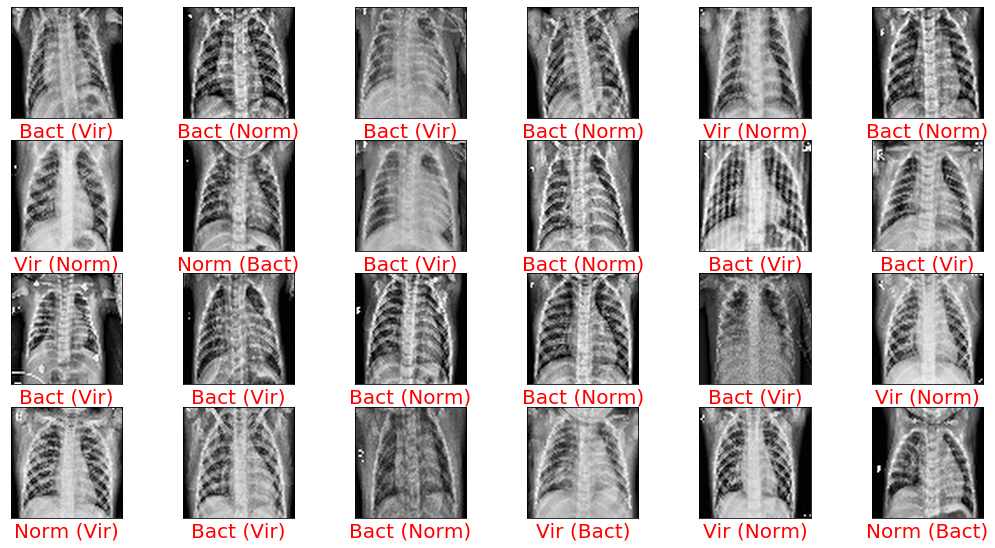

In [53]:
# PLOT SOME ERRORS
errors=[ i for i in range(len(x_test)) 
        if y_pred[i]!=y_test_singleDigit[i]]
errors=errors[:min(24, len(errors))]
plot_images(x_test, y_test_names, errors[:55], 
            columns=6, x_size=3, y_size=2, y_pred=y_pred_names)